# Задание 

1. Проверить гипотезу руководителя продукта. У него есть опасение, что из-за проблем с доставкой товаров в магазине у нас стали **больше оттекать пользователи**. Он просит вас сравнить, на сколько сейчас все хуже, чем в прошлом году 

2. Дать руководителю продукта инструмент для самостоятельного принятия решений по качеству удержания пользовательской базы

# Инструмент 

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df_orders = pd.read_csv('orders.csv')
df_customers = pd.read_csv('customers.csv')

df_customers.rename(columns={'id': 'customer_id'}, inplace=True)
df = df_orders.merge(df_customers, how='left', on='customer_id')

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
df

,id,order_date,ship_mode,customer_id,sales,name,segment,state,city
0,100006,2014-09-07,Standard,DK-13375,377.970,Dennis Kane,Consumer,Ohio,Marion
1,100090,2014-07-08,Standard,EB-13705,699.192,Ed Braxton,Corporate,Ohio,Akron
2,100293,2014-03-14,Standard,NF-18475,91.056,Neil Franzosisch,Home Office,Illinois,Rockford
3,100328,2014-01-28,Standard,JC-15340,3.928,Jasper Cacioppo,Consumer,California,Los Angeles
4,100363,2014-04-08,Standard,JM-15655,21.376,Jim Mitchum,Corporate,New Jersey,Bridgeton
...,...,...,...,...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368,Jack O'Briant,Corporate,Pennsylvania,Philadelphia
5005,169320,2017-07-23,Second,LH-16900,171.430,Lena Hernandez,Consumer,Delaware,Dover
5006,169488,2017-09-07,First,AA-10375,56.860,Allen Armold,Consumer,Arizona,Mesa
5007,169502,2017-08-28,Standard,MG-17650,113.410,Matthew Grinstein,Home Office,Pennsylvania,Philadelphia


### Распределение интервалов повторных заказов

Рассчитаем интервалы заказов для каждого клиента и рассмотрим распределение этого показателя

In [5]:
df['order_date'] = pd.to_datetime(df['order_date'])
df.sort_values(by=['customer_id', 'order_date'], inplace=True)

df['diff'] = df['order_date'].diff()

mask = df.customer_id != df.customer_id.shift(1)
df.loc[mask, 'diff'] = np.nan

C:\Users\walde\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\walde\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


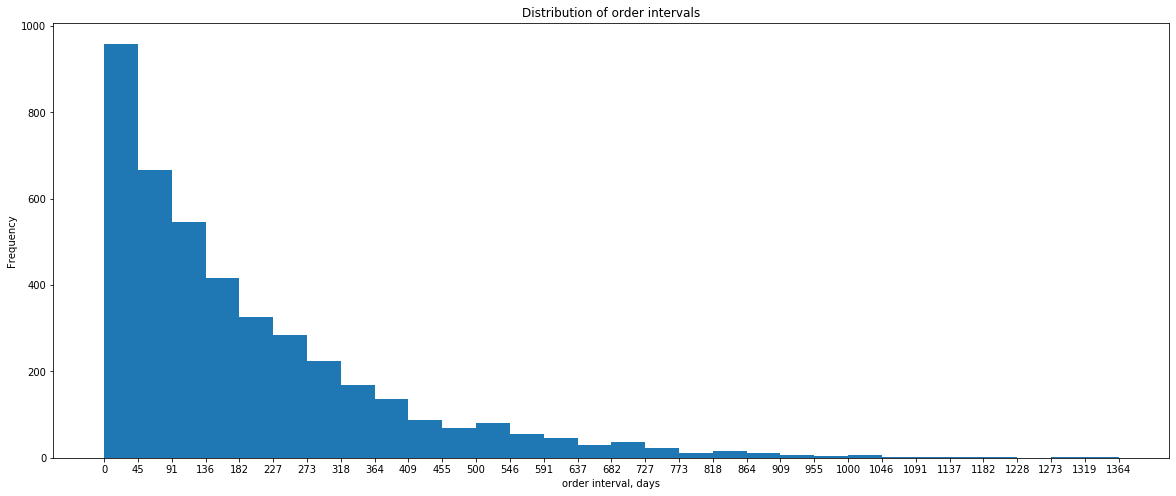

In [6]:
fig = plt.figure(figsize=(20,8))

n, bins, patches = plt.hist(df['diff'].dt.days, bins=30)
plt.xticks(bins)
plt.title('Distribution of order intervals')
plt.xlabel('order interval, days')
plt.ylabel('Frequency')
plt.show()

In [7]:
df['order_year'] = df['order_date'].dt.year

In [8]:
# Медиана интервала заказа в днях за весь доступный период
df['diff'].median()

Timedelta('128 days 12:00:00')

In [9]:
# Медиана интервала заказа в днях за 2016
df.loc[df['order_year']==2016, 'diff'].median()

Timedelta('146 days 00:00:00')

In [10]:
# Медиана интервала заказа в днях за 2017
df.loc[df['order_year']==2017, 'diff'].median()

Timedelta('121 days 00:00:00')

In [11]:
# Доля повторных заказов в пределах 30 дней
mask = df['diff'].dt.days < 30
df.loc[mask, 'diff'].count()/df['diff'].count()

0.1627134724857685

#### Вывод:
На графиках видно, что распределение интервалов заказов имеет достаточно тяжелый правый хвост. Только 16% заказов осуществляются клиентами повторно в пределах 30 дней после предыдущего заказа. Чтобы сгладить результаты, имеет смысл использовать квартальные периоды для когортного анализа

In [12]:
df['order_quarter'] = df['order_date'].dt.to_period('Q')

In [13]:
cohorts = df.groupby('customer_id').agg(Cohort=('order_quarter', 'min'))

In [14]:
df = df.merge(cohorts, how='left', on='customer_id')

In [15]:
df

,id,order_date,ship_mode,customer_id,sales,name,segment,state,city,diff,order_year,order_quarter,Cohort
0,128055,2014-03-31,Standard,AA-10315,726.548,Alex Avila,Consumer,Minnesota,Minneapolis,NaT,2014,2014Q1,2014Q1
1,138100,2014-09-15,Standard,AA-10315,29.500,Alex Avila,Consumer,Minnesota,Minneapolis,168 days,2014,2014Q3,2014Q1
2,121391,2015-10-04,First,AA-10315,26.960,Alex Avila,Consumer,Minnesota,Minneapolis,384 days,2015,2015Q4,2014Q1
3,103982,2016-03-03,Standard,AA-10315,4406.072,Alex Avila,Consumer,Minnesota,Minneapolis,151 days,2016,2016Q1,2014Q1
4,147039,2017-06-29,Standard,AA-10315,374.480,Alex Avila,Consumer,Minnesota,Minneapolis,483 days,2017,2017Q2,2014Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5004,143336,2014-08-27,Second,ZD-21925,244.760,Zuschuss Donatelli,Consumer,California,San Francisco,NaT,2014,2014Q3,2014Q3
5005,167682,2016-04-03,Standard,ZD-21925,331.080,Zuschuss Donatelli,Consumer,California,San Francisco,585 days,2016,2016Q2,2014Q3
5006,147991,2016-05-05,Standard,ZD-21925,16.720,Zuschuss Donatelli,Consumer,California,San Francisco,32 days,2016,2016Q2,2014Q3
5007,152471,2016-07-08,Same Day,ZD-21925,839.944,Zuschuss Donatelli,Consumer,California,San Francisco,64 days,2016,2016Q3,2014Q3


### Когортный анализ коффициента удержания (retention rate)

In [16]:
cohorts_group = df.groupby(['Cohort', 'order_quarter']).agg(TotalUsers=('customer_id', pd.Series.nunique))

In [17]:
def cohort_period(df):
    """
    Creates column 'Cohort period'
    """
    df['Cohort period'] = np.arange(len(df))
    return df

cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)

In [18]:
cohorts_group.reset_index(inplace=True)
cohorts_group.set_index(['Cohort', 'Cohort period'], inplace=True)

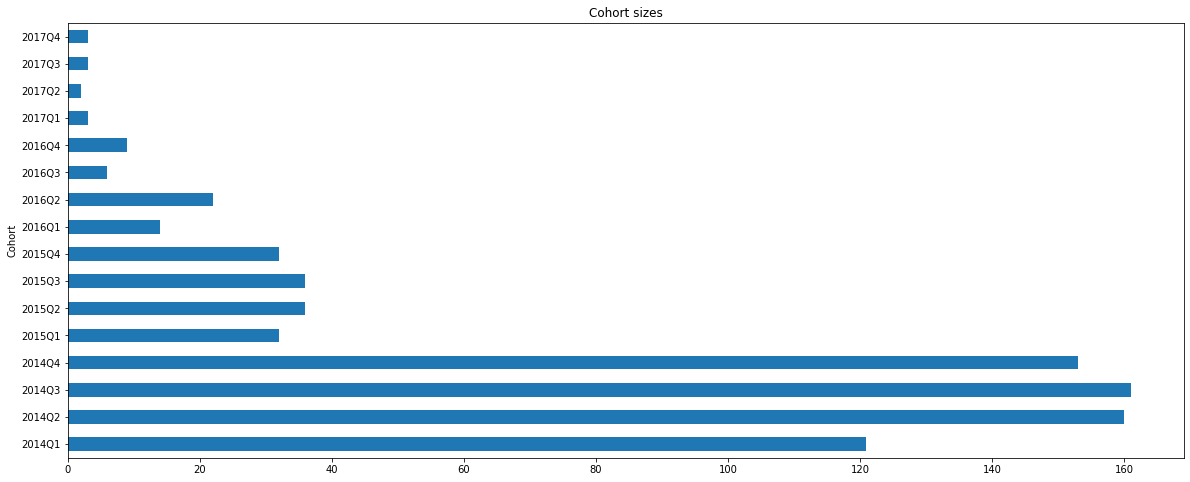

In [19]:
cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
cohort_group_size.plot.barh(figsize=(20, 8))
plt.title('Cohort sizes')
plt.show()

На графике "Cohort sizes" видно, что компания стала меньше привлекать новых клиентов в 2016-2017 гг.

Теперь нарисуем график для коэффициента удержания (retention rate). С его помощью можно оценить активность клиентской базы (сегментированной по времени привлечения) и получить ответ на вопрос по поводу увеличения оттока клиентов.

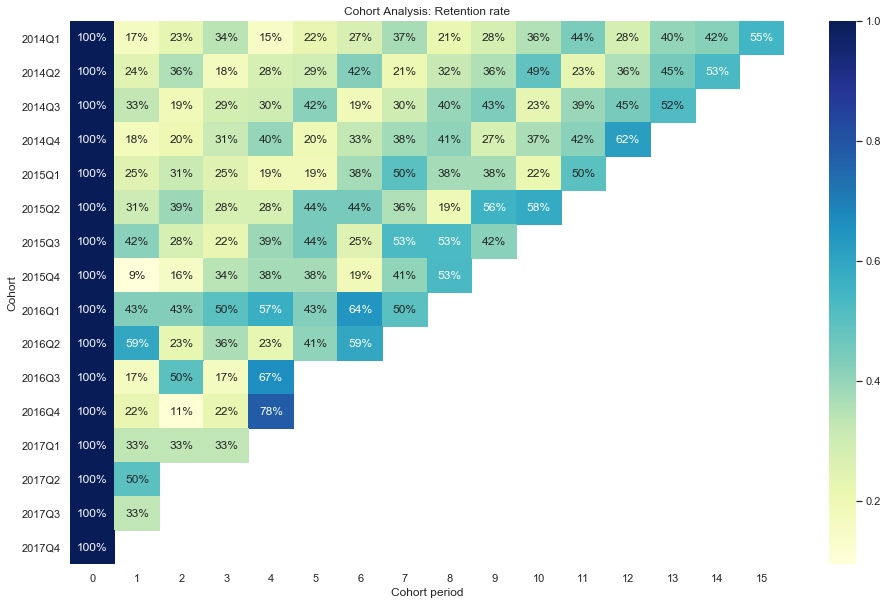

In [20]:
user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1).T

sns.set(style='white')
plt.figure(figsize=(16, 10))
plt.title('Cohort Analysis: Retention rate')
sns.heatmap(user_retention, mask=user_retention.isnull(), annot=True, fmt='.0%', cmap="YlGnBu");

#### Ключевые выводы:

1. **Старая клиентская база продолжает пользоваться услугами компании.** У клиентов, привлеченных до третьего квартала 2016 года, наблюдается рост активности за 2017 год. Такая высокая активность старой клиентской базы особенно актуальна в 4 кв. 2017 года. Практически в каждой кагорте можно заметить рост доли активных пользователей за этот квартал по сравнению с 4 кв. 2016 года.

2. **Для некоторых кагорт наблюдается полное отсутствие активности в 4 кв. 2017 года**. Это касается кагорт пользователей, привлеченных во втором квартале 2017 и в третьем квартале 2016 года. За эти периоды было привлечено очень мало пользователей: 2 человека и 6 человек, соответственно. Такие нестабильные результаты по коэффициенту удержания (падение с 50-67% до 0%) можно объяснить небольшим размером выборки по указанным когортам.

3. **В целом на основе проведенного анализа коэффициента удержания мы не можем сказать, что произошел рост оттока клиентов за 2017 год.** Наиболее многочисленные когорты активизировали заказы за 2017 год. Низкая доля активности наблюдается в основном в когортах малого размера, привлеченных после второго квартала 2016 года.
